# Classification Lab
## Data Preparation Part 1
<p class="lead">We have been tasked by <em>First Faux Union Bank</em> with developing an algorithm for classifying candidates more likely to sign up for a terms deposit based on historical data.  This <a href="https://jupyter.org/">Jupyter notebook</a>
shows our process for developing the classification model. </p>

<p>COLLABORATORS: Ruhaab Markas, Tommy Pompo, Griffin Lane, Iram Bakhtiar</p>

<br>
<div class="alert alert-warning">
<b>Assignment:</b> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.<br><br>
Also, we got marked off last time for not talking about the business side of the mini lab even though the rubric did not mention it at all so we should probably include that in our Markdown as well.
</div>

In [14]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use(['seaborn-dark-palette'])

#Import dataset
df = pd.read_csv("bank-additional-full.csv", sep=";")

#View column names
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [15]:
yes_count, no_count = len(df[df.y == "yes"]), len(df[df.y == "no"])
total = yes_count+no_count
print("""
                Yes:   {0}   {1:3.2f}%
                No:    {2}  {3:3.2f}%
                Total: {4}
""".format(yes_count,yes_count/total*100,
           no_count, no_count/total*100, total))


                Yes:   4640   11.27%
                No:    36548  88.73%
                Total: 41188



> <p><b>Interpretation:</b> This is definitely not ideal.  Any internal cross validation will be working with an extremely low number of <b>yes</b> observations.  Later on, we can mitigate the damage of the extremely one-sided response variable using upsampling, downsampling, and/or stratified subset selections.</p><p>  Upsampling the <b>yes</b> votes increases the risk of overfitting since the observations are repeated and are then weighted.  We could also simply weight the <b>yes</b> observations more for the same effect. </p><p>Downsampling the <b>no</b> observations sacrifices potentially useful data for separation and would have to be used very sparingly</p><p>The best option is to stratify any subsetting of our data.  That will help ensure that we subset groups representative of the larger dataset.</p>

In [16]:
df = df.drop(["duration"], axis=1)

> <p>It doesn't make sense to include the duration of the phone call for prediction purposes.  The call length is not something we will know in advance so we cannot use its value in a classifying model.</p>

In [17]:
df.columns[df.isnull().sum() > 0]

Index([], dtype='object')

> <p>Excellent! it looks like there are no null values to deal with.  Let's move on to distribution assessment.</p>

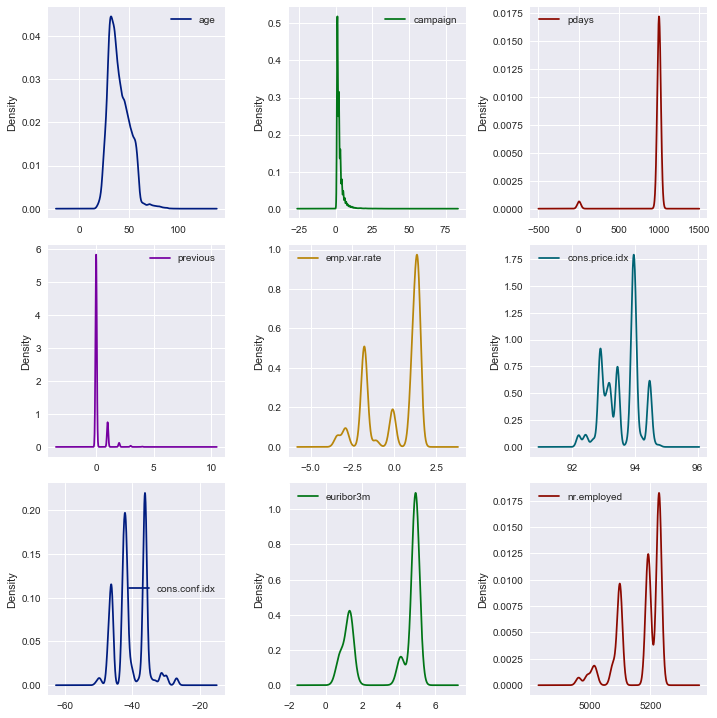

In [18]:
df.plot(kind='density', subplots=True, layout=(3,3), sharex=False, figsize=[10,10])

plt.tight_layout(pad=0.8, w_pad=1.8, h_pad=1.0)

> <p><b>Interpretation:</b> These distributions are not ideal but they may be passable for this analysis since almost none of the transformations we applied seemed to help much; below you will see an example.  Fortunately they appear to have low standard deviations which means that we are likely to predict close to the average value.</p>

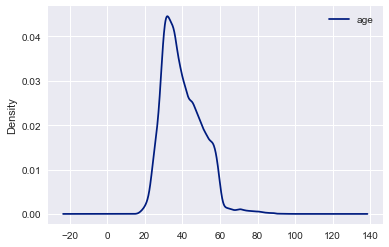

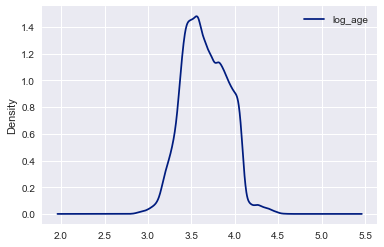

In [19]:
import numpy as np
df.age.plot(kind="density", label="age")
plt.legend(loc='upper right')
plt.show()

log_age = df.age.apply(np.log)
log_age.plot(kind="density", label="log_age")
plt.legend(loc='upper right')
plt.show()

df.age = log_age

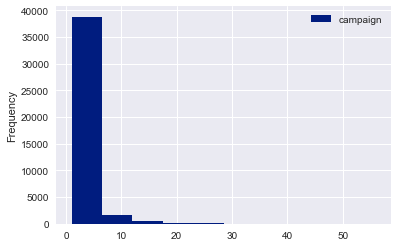

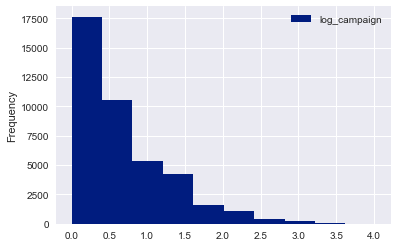

In [20]:
import numpy as np
import math

df.campaign.plot(kind="hist", label="campaign")
plt.legend(loc='upper right')
plt.show()

#add epsilon to prevent logs of zero
log_campaign = df.campaign.apply(np.log)
log_campaign.plot(kind="hist", label="log_campaign")
plt.legend(loc='upper right')
plt.show()

#df.campaign = log_campaign

> <p><b>Interpretation:</b> After applying log transformations on several different attributes, age seems to fit a more normal distribution. Since the distribution is noticably better, we will replace <b>age</b> with the transformed version. Based on other exploratory transformations, not include in this notebook for conciseness, there were not any notable improvements to the distributions of other features from transformations. Therefore, we will exclude any other transformation besides age. A transformation for campaign is also included above to illustrate how transformation are not always valuable, but still an important step in data cleansing. </p> </p>

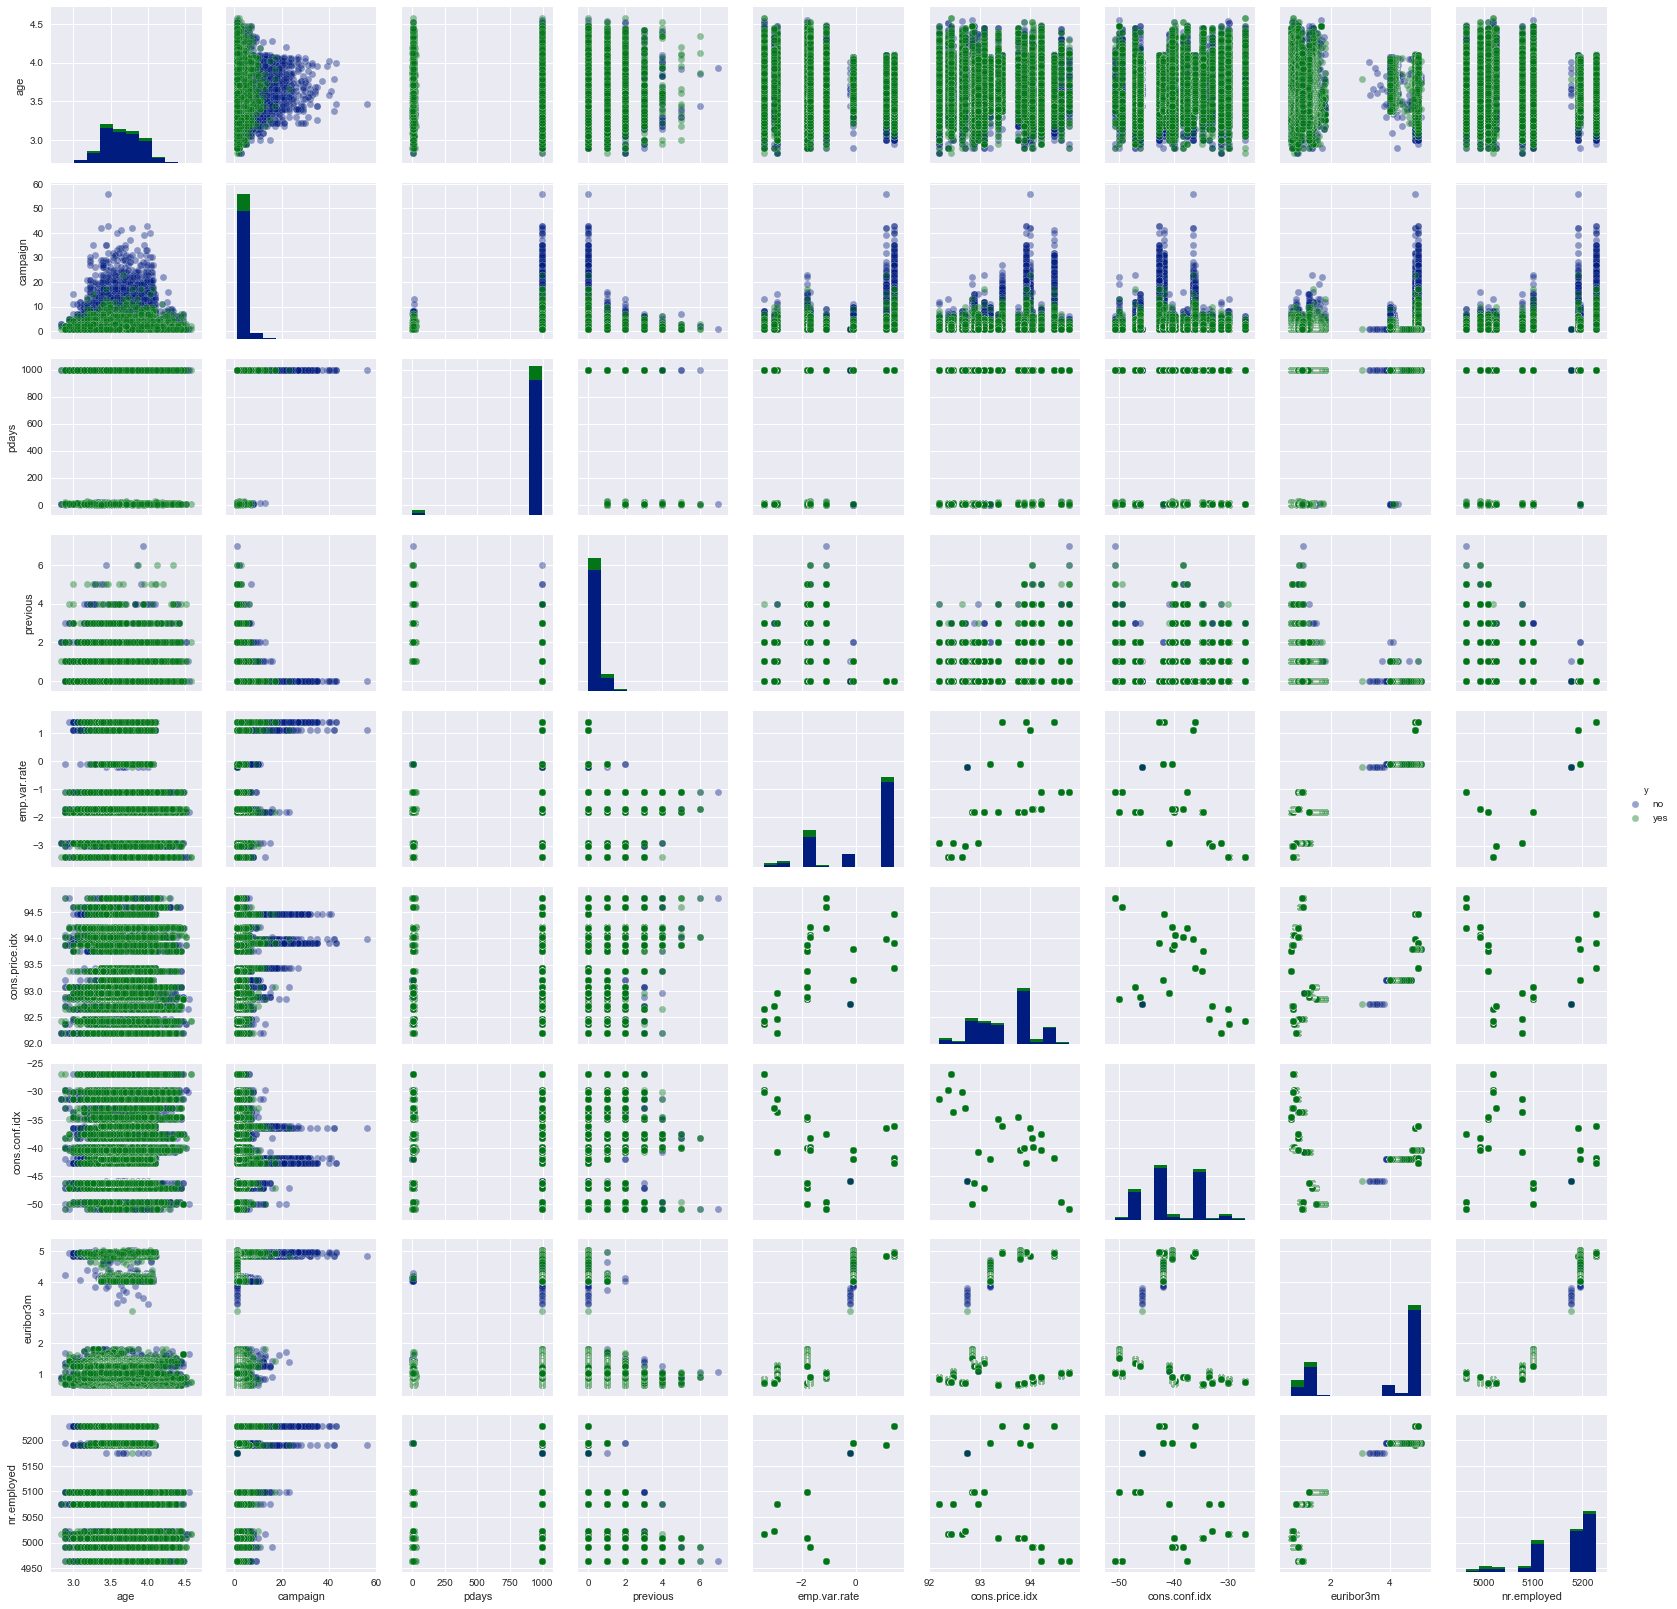

In [21]:
sns.pairplot(df, hue="y", diag_kind="hist", plot_kws={"alpha":.4})

> <p><b>Interpretation:</b> With term deposits (<font color='green'>yes</font>) being green and the lack of the term deposit (<font color='blue'>no</font>) being blue, the pairplot above indicates that strong linear separation is most supported by <b>age</b>, <b>campaign</b>, whether or not the customer had previously signed up for the term deposit, and the current consumer confidence interval (<b>CCI</b>).</p>

> <p>Notice the distributions running along the diagonal are not ideal, even after our modifications to them. Looking at the distributions of the variables, it is evident that they all have varying skewness. It will be helpful to look at whether transformations fit more normal distributions so that we are meeting more assumptions of the models. The first type of transformation that we will explore is log10 transformation. Given that the age and campaign variables follow the closest normal spread we will apply the log transformation to them first.</p>

> <p>The visible separation between groups could be better but, we should be able to construct a relatively accurate classifier regardless. Of greater concern is the extremely one-sided nature of our response variable, as mentioned throughout this analysis.</p>

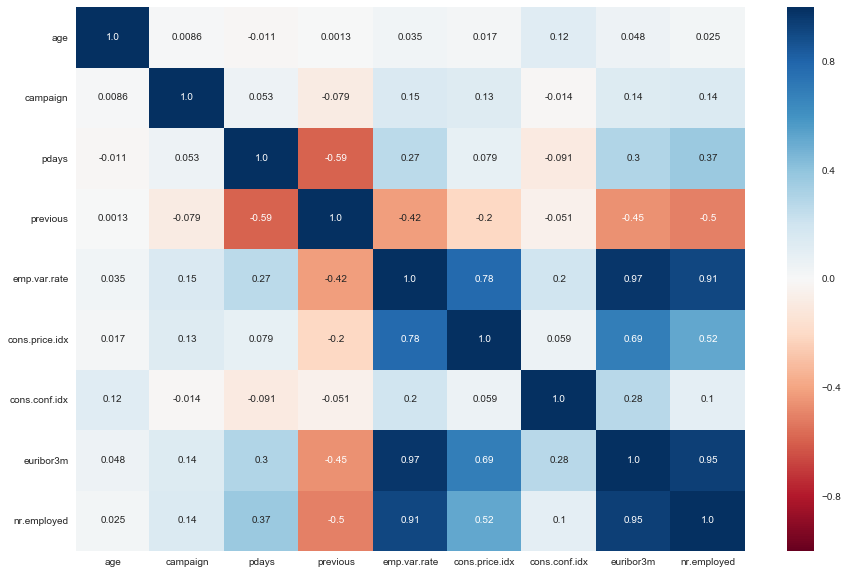

In [22]:
corr = df.corr()
plt.figure(figsize=[15,10])
sns.heatmap(corr,annot=True, fmt=".2", cmap="RdBu")

> <p><b>Interpretation:</b> The heatmap above is a colorized correlation matrix for easily spotting highly dorrelated variables.  A strong negative correlation is depicted with a <b><font color='darkred'>dark red</font></b> square while a strong positive correlation is depicted with a <b><font color='darkblue'>strong blue</font></b>.  The absolute value or magnitude of the value annoted in each cell (it is actually the $R^{2}$ value) is an indicator of how strong the correlation is quantitatively.</p>

> <p>From this correlation matrix we can see that <b>emp.var.rate</b> is highly correlated with many of the other variables. Another possible option to include in the backlog of future EDA is looking at the Variance Inflation Factor ad a measure of colinearity. Correlation and importance of the features to the response will be part of the modeling efforts in later sections.</p>

In [23]:
from sklearn.model_selection import train_test_split

#get y's
y = df.y

#get all but y, also drop duration as it is not suitable for prediction
X = df.drop(["y"], axis=1)

#quick and dirty one hot encoding, could have used sklearn's as well
def OneHot(dataset):
    if type(dataset) is pd.Series:
        return [0  if (x == "no") else 1 for x in df.y]    
    else:
        cats = dataset.select_dtypes(include=[np.object])
        cats_cols = cats.columns

    for i in enumerate(cats_cols):
        i = i[1]            
        one_h = pd.get_dummies(dataset[i])
        dataset = dataset.drop(i,axis=1)
        dataset[one_h.columns] = one_h        
    return dataset

X, y = OneHot(X), OneHot(y)



### Without External Cross Validation
# X_train = X
# y_train= pd.Series(y)

### With external cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
y_train, y_test = pd.Series(y_train), pd.Series(y_test)

In [24]:
from sklearn.preprocessing import StandardScaler

slr = StandardScaler()

X_train = slr.fit_transform(X_train)
X_test = slr.transform(X_test)

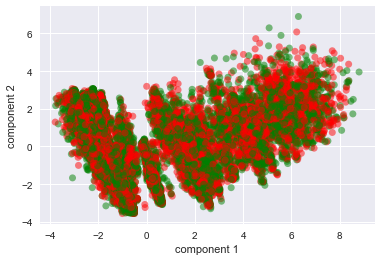

In [25]:
from sklearn.decomposition import PCA

pca_attribs = PCA(n_components=2).fit_transform(X_train)

X_train_pca = pca_attribs

X_train_pca = pd.DataFrame(X_train_pca, columns = ["PCA_1", "PCA_2"])

plt.scatter(X_train_pca["PCA_1"], X_train_pca["PCA_2"],
            c=['r', 'g'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')

> <p><b>Interpretation:</b> We attempted a Principal Component Analysis to see if there was good separation with only two principal components.  Unfortunately it does not appear from this view that there is good opportunity to split with a hyperplane in a manner that will produce any significant improvement.  We will attempt a 3D principal component analysis as well simply to see if there is a marked improvement.  If there is a marked improvedment, we may go the extra step and make a scree plot and select our PCA component count using that.</p>

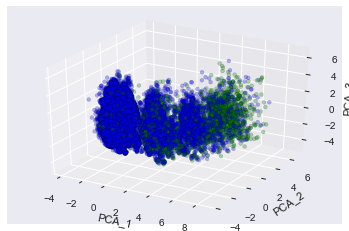

In [26]:
from mpl_toolkits.mplot3d import Axes3D

pca_attribs = PCA(n_components=3).fit_transform(X_train)

X_train_pca = pca_attribs

X_train_pca = pd.DataFrame(X_train_pca, columns = ["PCA_1", "PCA_2", "PCA_3"])

colors = ["green"  if (x == 1) else "blue" for x in y_train]

threedee = plt.figure().gca(projection='3d')

fig = threedee.scatter(X_train_pca["PCA_1"], X_train_pca["PCA_2"], X_train_pca["PCA_3"], c=colors, s=15,
                           edgecolor='none', alpha=.3,cmap=plt.cm.get_cmap('seismic', 10))

fig = plt.figure(figsize=(20,20))

threedee.set_xlabel('PCA_1')
threedee.set_ylabel('PCA_2')
threedee.set_zlabel('PCA_3')
plt.show()

> <p><b>Interpretation:</b> There does appear to be better separation for our primary target class.  The <b><font color='green'>green markers</font></b>  are the <font color='green'>positive</font> responses and the <b><font color='blue'>blue markers</font></b> are the <font color='blue'>negative</font> responses to the term loan.  We will make a scree plot to see if there is a notcable knee point which we can use to determine the number of prinicpal components we should use.</p>

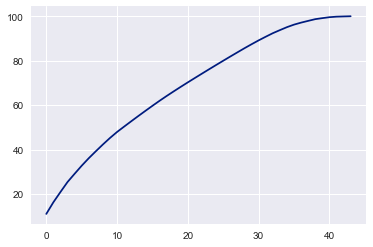

In [31]:
pca_final = PCA(n_components=44)

pca_final.fit(X_train)

#variance per principal component
var= pca_final.explained_variance_ratio_

#cumulative sum of the variance explained by pincipal components
var1=np.cumsum(np.round(pca_final.explained_variance_ratio_, decimals=4)*100)

#scree plot
plt.plot(var1)

> <p><b>Interpretation:</b> There may be a very slight knee point right around 10 principal components but it is not even close to a suitable amount of explained variance. Since we want to maximize our ability to detect <font color='green'>positive</font> responses from the target variable and, even with higher dimension of principal component analysis, we are likely to never separate all of the <font color='green'>positive</font> responses from the <font color='blue'>negative</font> responses just due to the way in which principal component analysis works.  Also, this dataset doesn't really have a need for dimensionality reduction.  At this point we will abandon further iterations of PCA.</p>

## Data Preparation Part 2
<p></p>

<p></p>

<br>
<div class="alert alert-warning">
<b>Assignment:</b>Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). </div>

> <p>There are three main modifications made to the base data set: </p>

> <p>The first was explorating different transformations of the continuous variables. Log transformations proved to only help one of the attributes, age. We replaced the <b>`age`</b> attribute with the transformed <b>`log_age`</b> attribute. </p>

> <p>Second, When evaluating the relevance of the variables we looked at a correlation heatmap of the attributes, relative to the response, as well as used our business domain knowledge to determine which attribute to drop. <b>`Duration`</b> was the only one that was removed from the dataset. This attribute measures the duration of the phone call, which is data we will not have for a campaign with new customers.</p> 

> <p>Third, we used one hot encoding for categorical variables. It’s important to note that when making dummy variables there needs to be consistency across the train test splits, as to how these variables are transformed. Now that we have explored our data, processed and cleansed it, we can begin our modeling efforts. </p>

> <p>Finally, the application of a standard scaler from scikit learn was used to normalize the data.</p>

In [13]:
#Bin campaign by over 2 and under 2 since it is the median value.
y_2 = X["campaign"] < 2

X_task_2 = X.drop(["campaign"], axis=1)

X_2 = OneHot(X_task_2)

X_2 = slr.fit_transform(X_2)

y_2 = y_2.astype("int")

## If Cross Validation is desired
# X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.10, stratify=y, random_state=42)

# y_2_train, y_2_test = pd.Series(y_2_train), pd.Series(y_2_test)

## Modeling and Evaluation 1

<div class="alert alert-warning">
<b>Assignment:</b> Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
</div>

> <p> <b>Precision</b>: This is computed based on the ratio of <b>True Positives</b> (<b>TP</b>) relative to the total number of positive predictions, including <b>False Positives</b> (<b>FP</b>). The formula is:</p><br>

> <center><font size=5>$ \frac{TP}{TP + FP}$</font></center>

> <p>it is a very insightful metric as it indicates how successfully the model is predicting positive outcomes. We are leveraging this metric to determine the precision of our ability to predict customers who will agree to the terms of our term deposit. This is an important statistic if we intend to use this model to identify candidates likely to agree to a term deposit. As a business we can narrow our focus to these customers to make marketing more personal, have outbound calls to these customer, and other approaches that would help solidify their conversion. For the aforementioned reasons, we will include precision in our model evaluation strategy.   </p>
<hr>
> <p><b>Recall</b>: This is also known as sensitivity. It indicates how the model retrieved instances of the predicted class to relative to the actual number of instances of that particular class. The formula for recall is:</p><br>

> <center><font size=5>$ \frac{TP}{TP + FN}$</font></center>

> <p>This is a useful metric to balance the insights gained from precision. Precision is great for relevancy but recall is useful for robustness and evaluating how complete the predictions are. As a business, we would leverage recall to continue tuning our model. A low recall score indicates that we are leaving customers behind from the personalization efforts (mentioned above) that could further supplement our marketing efforts. </p>

## Modeling and Evaluation 2

<div class="alert alert-warning">
<b>Assignment:</b>Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
</div>	

> <p>Stratified cross validation would make the most sense for this dataset due to the extremely one-sided nature of the target variable.  There is a strong predisposition for declining the term deposit and random sampling is likely to propagate and exacerbate this issue.  Using stratified cross validation we can representatively select from different stratified groups and get a more representative training set because it will preserve the diversity present in the dataset.</p>

> <p>The number of folds is not so easily determined, as there are advantages and disadvantages to having a larger or smaller k. The larger the k, the less bias there is, but also the more variance. With a large enough sample size however, this is less of an issue. Conversely, the smaller the k, the more bias and the less variance. With our data, we feel that we have a large enough sample size that we are comfortable going with 5 folds, which is large enough that it should significantly reduce the bias present in our data.</p>

## Modeling and Evaluation 3

<div class="alert alert-warning">
<b>Assignment:</b>Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!
</div>




> ### Tasks

> <p><b>Task 1.</b>  The first classification task will be concerned with determining if the client is likely to sign up for the term deposit based on previous consumer data.</p>

> <p><b>Task 2.</b>  The second classification task will take the campaign column, which is a count of the number of previous capmpaigns for the term deposit that have been made, and bin them into <b>3 difficulty categories</b>.  These categories will be able to be interpretted as a blend of the difficulty in obtaining the customer agreement for the term loan and a rough estimate of the amount of corporate time spent advertising to those consumers.  Classification of this column is useful for predicting how much time a salesperson is liable to spend trying to persuade the patron to agree to the term deposit.</p>

<hr>
### <b>Term Deposit Classification Task</b>

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from ipywidgets import FloatProgress
from IPython.display import display

#Include this to exclude warnings generated
#when there are no predicted samples but we
#have called the cross_val_score() for precision
import warnings
warnings.filterwarnings('ignore')

def avg_criteria(arr, folds, cv_count=3):
    
    return "{0}".format(sum(sum(arr)/len(arr))/cv_count)
#     return "{0}%".format(sum(sum(arr))/(cv_count*folds)*100)


def evaluate_stratified_models(folds, models, criteria, X_set, y_set, cv_count = None):    
    #Establish fold count for stratified k-fold cross validation
    skf = StratifiedKFold(n_splits=folds)
    
    #Create a progress bar so we can see our progress as we make it
    max_count = folds*3
    bar = FloatProgress(min=0, max=max_count)
    display(bar)
    
    #create a dictionary for holding the scores
    scores={}
    
    #enumerate the different training/test splits
    for k, (train, test) in enumerate(skf.split(X_set, y_set)):
            
        #iterate through the models
        for model in models:
            
            #Create keys if they don't exist so we can populate scores
            if model not in scores:
                scores[model] = {} 
                scores[model]["correct"] = {}
                scores[model]["incorrect"] = {}
            fold_name = "fold_"+str(k+1)
            if fold_name not in scores[model]["correct"]:
                scores[model]["correct"][fold_name] = []
                scores[model]["incorrect"][fold_name] = [] 

            #fit the model on the split
            models[model].fit(X_set[train], y_set.iloc[train])

            #Get the requested criteria from the cross validation scorer
            for crit in criteria:
                if crit not in scores[model]: scores[model][crit] = list()
                scores[model][crit].append(cross_val_score(models[model], X_set[test], y_set.iloc[test],
                                                           scoring=crit, cv=cv_count, n_jobs=-1))

            #Get indexes of correct and incorrect predictions for analysis on a per model basis
            y_hat = models[model].predict(X_set[test])  
            for j, i in zip(range(len(test)), test):
                if y_hat[j] == y_set[i]:
                    scores[model]["correct"][fold_name].append(i)
                else:
                    scores[model]["incorrect"][fold_name].append(i)        

            bar.value += 1
    return scores

In [15]:
%%time

#Establish fold count for stratified k-fold cross validation
folds = 5

#Define the model hyperparameters for each of the models
knn = KNeighborsClassifier(n_neighbors=2)
svm = SVC(random_state=42)
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)

#Create a dictionary of our models and a list of our desired criteria
models = {"knn":knn,"svm":svm,"rf":rf}
criteria = ["recall", "precision"]

#Use our model evaluation function to create a dictionary for holding the scores
scores = evaluate_stratified_models(folds, models, criteria, X_train, y_train)

# NOTE: You may see a warning about no predicted samples, that means that the number of predicted "yes" samples
#       for that cross validation set is 0 and the precision calculations cannot be performed with 0 samples.

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Wall time: 10min 38s


###### KNN

In [16]:
print("average recall over folds: ", avg_criteria(scores["knn"]["recall"], folds))
print("average precision over folds: ", avg_criteria(scores["knn"]["precision"], folds))

average recall over folds:  0.15015514470144312
average precision over folds:  0.5054685188581901


###### SVM

In [17]:
print("average recall over folds: ", avg_criteria(scores["svm"]["recall"], folds))
print("average precision over folds: ", avg_criteria(scores["svm"]["precision"], folds))

average recall over folds:  0.1970887805884325
average precision over folds:  0.646056560788857


###### Random Forest

In [18]:
print("average recall over folds: ", avg_criteria(scores["rf"]["recall"], folds))
print("average precision over folds: ", avg_criteria(scores["rf"]["precision"], folds))

average recall over folds:  0.2653326800924852
average precision over folds:  0.5404359739000165


<hr>
### <b>Campaign Difficulty Classifier<b>

In [19]:
%%time

#Define the model hyperparameters for each of the models
knn_campaign = KNeighborsClassifier(n_neighbors=5)
svm_campaign = SVC(random_state=42)
rf_campaign = RandomForestClassifier(n_estimators=15, oob_score=True, random_state=42)

#Create a dictionary of our models, we can use the same criteria since it makes sense to
models = {"knn":knn_campaign,"svm":svm_campaign,"rf":rf_campaign}

#Use our model evaluation function to create a dictionary for holding the scores
scores_campaign = evaluate_stratified_models(5, models, criteria, X_2, y_2)

# NOTE: You may see a warning about no predicted samples, that means that the number of predicted "yes" samples
#       for that cross validation set is 0 and the precision calculations cannot be performed with 0 samples.
#       This cell does produce a lot of warnings though due to poor predictive capability for task 2. You may
#       want to suppress them up in the function declaration block above by uncommenting the warnings filtering.

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Wall time: 13min 12s


###### KNN

In [20]:
print("average recall over folds: ", avg_criteria(scores_campaign["knn"]["recall"], folds))
print("average precision over folds: ", avg_criteria(scores_campaign["knn"]["precision"], folds))

average recall over folds:  0.39448273503680714
average precision over folds:  0.5165493493711475


###### SVM

In [21]:
print("average recall over folds: ", avg_criteria(scores_campaign["svm"]["recall"], folds))
print("average precision over folds: ", avg_criteria(scores_campaign["svm"]["precision"], folds))

average recall over folds:  0.32817084636176763
average precision over folds:  0.4927996886427794


###### Random Forest

In [22]:
print("average recall over folds: ", avg_criteria(scores_campaign["rf"]["recall"], folds))
print("average precision over folds: ", avg_criteria(scores_campaign["rf"]["precision"], folds))

average recall over folds:  0.346127352101985
average precision over folds:  0.4265876434768458


> <p><b>Interpretation:</b> At this point it is apparent that we do not have enough data to accurately classify campaign.  For now, since this analysis is not critical, we will delay this analysis until we have gotten more accepted term loan records in our dataset.  If our first task is successful, the second task will become easier to predict. We will end up with more data with which to fit our models.</p>

## Modeling and Evaluation 4

<div class="alert alert-warning">
<b>Assignment:</b>Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
</div>	


> <p>The method of evaluation we chose was `recall`.  Recall is a measure, in this case, of how accurately we classified the positive response to the term deposit package campaign.  We would much rather reach out to a few uninterested parties than miss out on a single interested party. For this reason we have chosen `recall` as it is the most logical scoring criteria. </p>
> <p>There is a limit to this however, we would like to still limit the number of false positive classifications we encounter.  For this reason, `recall` is often paired with `precision`.  The two scores together facilitate selection of a model that minimizes this count to a reasonable range.  You will notice a tradeoff in between these two values.</p>

> <p>The higher the `recall`, the lower the `precision` might be due to a wider margin which leads to the inclusion of more false positive points.</p>

In [23]:
def get_criteria(model, criteria):    
    temp = pd.DataFrame(scores[model][criteria],
                        columns=["cv_1","cv_2","cv_3"],
                        index=["fold_"+str(x+1) for x in range(folds)])
    return temp.transpose()

In [24]:
knn_prec = get_criteria("knn", "precision")

svm_prec = get_criteria("svm", "precision")

rf_prec = get_criteria("rf", "precision")

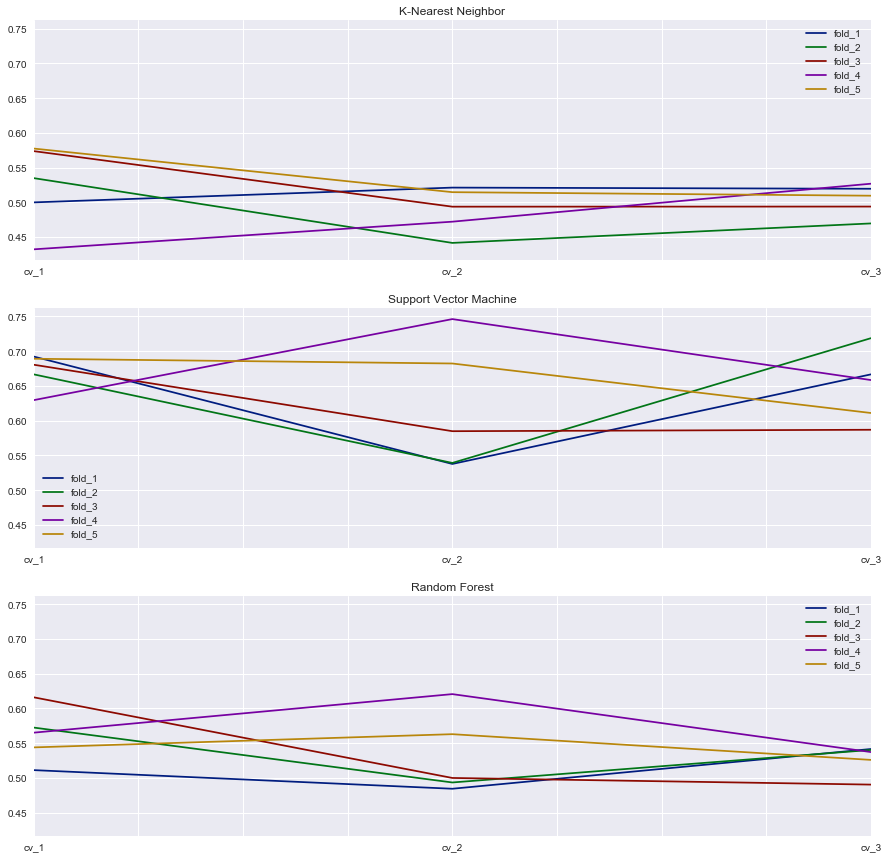

In [25]:
fig, axarr = plt.subplots(3,1, sharey=True, figsize=[15,15])    

axarr[0].title.set_text("K-Nearest Neighbor")
knn_prec.plot(ax=axarr[0])

axarr[1].title.set_text("Support Vector Machine")
svm_prec.plot(ax=axarr[1])

axarr[2].title.set_text("Random Forest")
rf_prec.plot(ax=axarr[2])

plt.show()

Individual Fold Distributions:


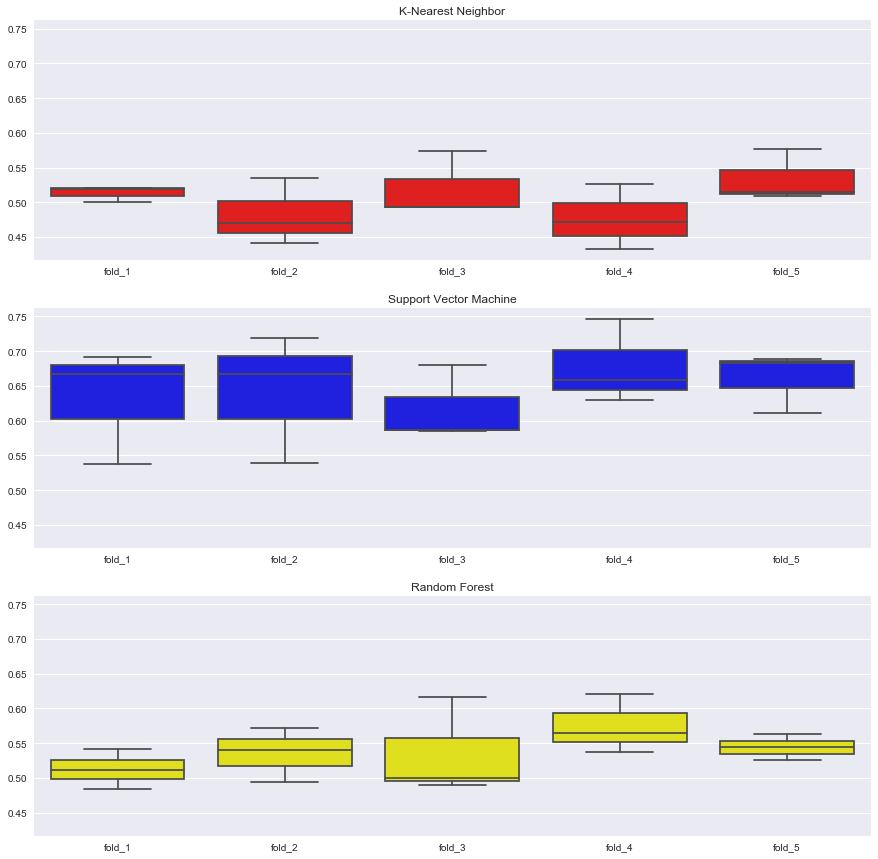

In [26]:
fig, axarr = plt.subplots(3,1, sharey=True, figsize=[15,15]) 

axarr[0].title.set_text("K-Nearest Neighbor")
sns.boxplot(rf_prec, color="yellow", ax=axarr[2])
axarr[1].title.set_text("Support Vector Machine")
sns.boxplot(svm_prec, color="blue", ax=axarr[1])
axarr[2].title.set_text("Random Forest")
sns.boxplot(knn_prec, color="red", ax=axarr[0])

print("Individual Fold Distributions:")
plt.show()

> <p><b>Interpretation:</b> This grid shows the performance of each model over each individual fold.  From this visualization we can infer that the <b>Random Forest</b> tends to perform poorly on the same folds that the <b>Support Vector Machine</b> tends to perform poorly on.  If we were looking for algorithms to use in ensemble, we would want models that make very different kinds of mistakes so we could combine their collective predictive power.  Plots like this can help to see that sort of relationship as well as see how consistent our performance was for our cross validation across each of the folds.</p>

Average Distributions:


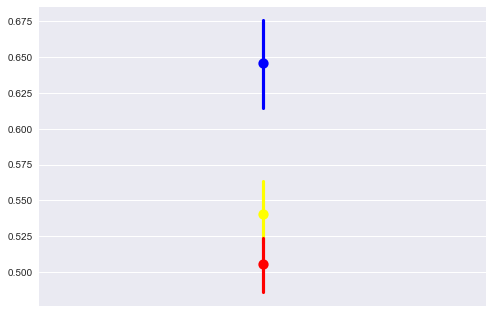

In [27]:
sns.pointplot(rf_prec, color="yellow", orient='vertical')#, ax=axarr[2])
sns.pointplot(svm_prec, color="blue", orient='vertical')#, ax=axarr[1])
sns.pointplot(knn_prec, color="red", orient='vertical')#, ax=axarr[0])

print("Average Distributions:")
plt.show()

> <p><b>Interpretation:</b> This plot indicates that the <b>SVM</b> model performs better, on average, than the other models.  It helps to provide support for the argument that the <b>SVM</b> is the superior model.

### External Cross Validation

In [28]:
y_hat = knn.predict(X_test)
print(classification_report(y_test, y_hat))        

             precision    recall  f1-score   support

          0       0.90      0.98      0.94      3655
          1       0.49      0.14      0.22       464

avg / total       0.85      0.89      0.86      4119



In [29]:
y_hat = svm.predict(X_test)
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

          0       0.91      0.99      0.95      3655
          1       0.65      0.22      0.33       464

avg / total       0.88      0.90      0.88      4119



In [30]:
y_hat = rf.predict(X_test)
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

          0       0.91      0.97      0.94      3655
          1       0.52      0.29      0.37       464

avg / total       0.87      0.89      0.88      4119



> <p><b>Interpretation:</b> The classification reports above indicate relatively low scores for the `recall` and `precision` associated with our target variable, `1`, for each of the three models.  The worst model without question is the K-Nearest Neighbors model.  It has the lowest `recall` and `precision` of all the models.  The `Random Forest` model has the highest recall but has worse `precision`, meaning more uninterested patrons being advertised to.  The `Support Vector Machine` model is a little worse at differentiating all the potentially interested customers from the uninterested, in fact the precision is `.50`, but is better at reaching potentially interested customers from the pool of data. </p>

> <p></p>

### Modeling and Evaluation 5

<div class="alert alert-warning">
<b>Assignment:</b>Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
</div>	

> <p>Since the <b>f1 score</b> is a weighted average of the recall and precision, it can be used to roughly compare models when their classification reports seem similar or you are unsure of the value of the tradeoff between <b>precision</b> and <b>recall</b>. In our case the <b>f1 score</b> for the <b>Random Forest</b> is <b>.37</b> and the score for the <b>Support Vector Machine</b> is <b>.34</b>.</p>

> <p>Since these were the only two models pending further consideration, we can use that <b>f1 score</b> to help make a decision as to which model is superior.  </p>

#### Nemar's Test


> <p>Nemars test is a way to compare classification algorithms that uses the central limit theorem to determine whether or not the difference in performance is outside of the 95% confidence interval for expected deviations in performance. It uses the following formula:</p>

> <center><font size=6>$ \frac{(\vert n_{10} - n_{01}\vert - 1)^{2}}{n_{10} + n_{01}}$</font></center>

> <p>Where <font size=4><b>$ n_{10} $</b></font> is the number of predictions model `A` predicts correctly that model `B` does not and <font size=4><b>$n_{01}$</b></font> is the number that model `B` predicts correctly that model `A` does not.</p>

In [31]:
def Nemar(model_a, model_b):
    results_per_fold =[]
    for x in model_a["correct"]:
        a_adv = set(model_a["correct"][x]) & set(model_b["incorrect"][x])
        b_adv = set(model_a["incorrect"][x]) & set(model_b["correct"][x])
        
        a_count = len(a_adv)
        b_count = len(b_adv)
        if a_count is 0 & b_count is 0: 
            results_per_fold.append(0) 
        else:
            results_per_fold.append( ((np.abs(b_count-a_count) - 1 )**2) / (b_count+a_count) )
    return results_per_fold 

In [32]:
#Get the mean Nemar scores across the stratified folds
print("Support Vector and KNN Nemar: ", np.mean(Nemar(scores["svm"], scores["knn"])))
print("Random Forest and KNN Nemar: ", np.mean(Nemar(scores["rf"], scores["knn"])))
print("Random Forest and SVM Nemar: ", np.mean(Nemar(scores["rf"], scores["svm"])))

Support Vector and KNN Nemar:  18.489983634633106
Random Forest and KNN Nemar:  0.47927466670187807
Random Forest and SVM Nemar:  12.66004008358092


> <p>If the null hypothesis is correct, then the probability that this quantity is greater than `3.841459` is less than `0.05`.  This means it falls outside the confidence interval of the null hypothesis.  In our case, this number is well beyond that, which indicates the difference observed between the models' respective predictive capabilities is likely not due to probability or normal variance.</p>
> <p>Our results indicate that the predictive capabilities of the <b>Random Forest</b> and the <b>K-Nearest Neighbor</b> models are very close.  The <b>Support Vector Machine</b> model performed better than the KNN and its performance, as suggested by the Nemar test, was not due to probability.  The performance of the <b>Random Forest</b> has been brought into question now.  Due to this, and the relatively close <b>f1 scores</b>, we can feel comfortable selecting the <b>Support Vector Machine</b> model.</p>

> <p>After computing the error rate for the model (1-recall) we were able to calculate the sum of errors and mean error rate 
needed for the variance of the two models. The t statistic for 95% confidence with degrees of freedom [k (folds) - 1] is 2.28.</p>  

### Modeling and Evaluation 6

<div class="alert alert-warning">
<b>Assignment:</b>Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
</div>	

> ### <b>Importance</b>:
<p>The attributes `age`, `campaign`, `previous`, and `euribor3m` have the strongest separation for the primary target variable of interest (term deposit acceptance).</p>

### Deployment

<div class="alert alert-warning">
<b>Assignment:</b>How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
</div>	

In [33]:
yes_count, no_count = len(df[df.y == "yes"]), len(df[df.y == "no"])
total = yes_count+no_count
print("""
                Yes:   {0}   {1:3.2f}%
                No:    {2}  {3:3.2f}%
                Total: {4}
""".format(yes_count,yes_count/total*100,
           no_count, no_count/total*100, total))


                Yes:   4640   11.27%
                No:    36548  88.73%
                Total: 41188



> #### Current Model Value
> <p>Due to the very one-sided nature of our dataset, it is very important to continue to add new data to this classifier especially for successful sales of the term deposit package. Using this classifier as it stands should help to identify candidates more likely to agree to the term deposit but, as more records are created, its ability to successfully identify viable candidates will improve.</p>
> <p>The models current value can be assessed by means of the precision and recall in regards to the positive responses to the target variable.  We care more about catching all possible candidates that are likely to accept the terms of the term deposit and are less concerned about inccorectly assuming a customer is interested in the term deposit.  In this way we can help the client to maximize their returns by ensuring we advertise to all parties likely ro be interested.</p>

> #### Levels of Deployment
> <p>Therefore, we believe it is important to implement the model at multiple levels in the business.  At a high level, the sales team should have access to the model for selecting the candidates for the receipt of certain offers.  At a lower level, the local branches should have access to the predicted classification of not only taking the term deposit agreement but also the estimated campaign difficulty.  The campaign column, which represents the number of previous attempts of sale of the term deposit, has been binned and used as a response variable to be used in a model.  This will allow the employee to determine, based on their own personal bandwith, if they have time to attempt the sale or if their time could be better spent elsewhere</p>

> #### Method of Deployment
> <p>Since there is a need for access to the model at all levels of bank management, we would likely deploy the model over a server on AWS.  We could use a moderately sized EBS storage for the data and use EC2 instances for computing the classification off of the current model. There are a few major benefits to this model:</p>

> * The EC2 servers used by the employees for running the classification are separate from the server that will be used to generate newer models with the updated data.

> * There could be a separate EC2 for running and generating new models and it would not affect the workers on the separate EC2 instances

> * Though this dataset is small, it may grow. Fortunately AWS is a very scalable solution if you can afford the AWS fees. For a dataset this small though the storage will be cheap.

> #### Adding Data
> <p>Adding data can be automated through software to add records to the AWS repository directly. It is important to sanitize those database entries first though before adding them to your AWS storage. Inputting raw data directly into your cloud storage puts your company's data and your customers at risk. Safe weekly or monthly "pushes" to the remote repository is probably the safer route as a database manager would have time to curate the entries.  This also would help to prevent erroneous output from teh model.</p>